In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#export
import nb_002
from nb_002c import *

import operator

In [3]:
DATA_PATH = Path('../data')
PATH = DATA_PATH/'caltech101' # http://www.vision.caltech.edu/Image_Datasets/Caltech101/

# Caltech 101

## Create validation set

The first step will be to create a dataset from our files. We need to separate a definite amount of files to be used as our validation set. We will do this randomly by setting a percentage apart, in this case 0.2.

In [4]:
classes = ["airplanes", "Motorbikes", "BACKGROUND_Google", "Faces", "watch", "Leopards", "bonsai",
    "car_side", "ketch", "chandelier", "hawksbill", "grand_piano", "brain", "butterfly", "helicopter", "menorah",
    "trilobite", "starfish", "kangaroo", "sunflower", "ewer", "buddha", "scorpion", "revolver", "laptop", "ibis", "llama",
    "minaret", "umbrella", "electric_guitar", "crab", "crayfish",]

np.random.seed(42)
train_ds,valid_ds = ImageDataset.from_folder(PATH, valid_pct=0.2)

x = train_ds[1114][0]
def xi(): return train_ds[1114][0]
classes = train_ds.classes
c = len(classes)

len(train_ds),len(valid_ds),c

(7272, 1872, 102)

## Rectangular affine fix

torch.Size([3, 128, 192])


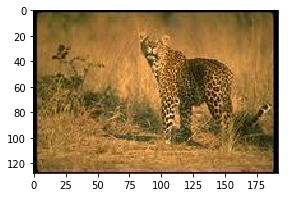

In [5]:
x.show(figsize=(6,3), hide_axis=False)
print(x.shape)

In [6]:
rot_m = np.array(rotate.func(40.)); rot_m

array([[ 0.76604444, -0.64278761,  0.        ],
       [ 0.64278761,  0.76604444,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

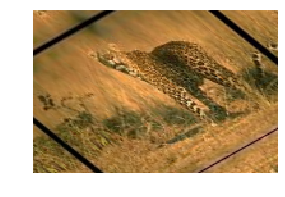

In [7]:
rotate(xi(), 40.).show(figsize=(6,3))

In [8]:
#export
def affine_mult(c:FlowField,m:AffineMatrix)->FlowField:
    "Multiply `c` by `m` - can adjust for rectangular shaped `c`"
    if m is None: return c
    size = c.size()
    _,h,w,_ = size
    m[0,1] *= h/w
    m[1,0] *= w/h
    c = c.view(-1,2)
    c = torch.addmm(m[:2,2], c,  m[:2,:2].t())
    return c.view(size)

nb_002.affine_mult = affine_mult

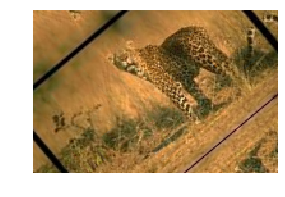

In [9]:
rotate(xi(), 40.).show(figsize=(6,3))

## Crop with padding

Now we are going to add padding or crop automatically according to a desired final size. The best way to do this is to integrate both transforms into the same function. 

We will do the padding necessary to achieve a _size x size_ (square) image. If _size_ is greater than either the height or width dimension of our image, we know we will need to add padding. If _size_ is smaller than either _height_ or _width_ dimension of our image, we will have to crop. We might have to do one, the other, both or neither. In this example we are only adding padding since both our _height_ and _width_ are smaller than 300, our desired dimension for the new _height_ and _width_.

As is the case with our original function, we can add a *row_pct* or *col_pct* to our transform to focus on different parts of the image instead of the center which is our default.

**Crop_pad**

Crop_pad crops and pads our image to create an output image according to a given target size.

_Parameters_

1. **Size** What is the target size of each side in pixels. If only one number *s* is specified, image is made square with dimensions *s* \* *s*.

    Domain: Positive integers.
    
2. **Padding_mode** What is the type of padding used in the transform.
    
    Domain: 'reflect', 'zeros', 'border'
    
3. **Row_pct** Determines where to cut our image vertically on the bottom and top when cropping (which rows are left out). If <0.5, more rows will be cut in the top than in the bottom and viceversa  (varies linearly).

    Domain: Real numbers between 0 and 1.
    
4. **Col_pct** Determines where to cut our image horizontally on the left and right when cropping (which columns are left out). If <0.5, more rows will be cut in the left than in the right and viceversa (varies linearly).

    Domain: Real numbers between 0 and 1.

Note: While experimenting take into account that this example image contains a thin black border in the original. This affects our transforms and can be seen when we use reflect padding.

In [10]:
#export
class TfmCrop(TfmPixel): order=99

@TfmCrop
def crop_pad(x, size, padding_mode='reflect',
             row_pct:uniform = 0.5, col_pct:uniform = 0.5):
    "Crop and pad tfm - `row_pct`,`col_pct` sets focal point"
    if padding_mode=='zeros': padding_mode='constant'
    size = listify(size,2)
    if x.shape[1:] == size: return x
    rows,cols = size
    if x.size(1)<rows or x.size(2)<cols:
        row_pad = max((rows-x.size(1)+1)//2, 0)
        col_pad = max((cols-x.size(2)+1)//2, 0)
        x = F.pad(x[None], (col_pad,col_pad,row_pad,row_pad), mode=padding_mode)[0]
    row = int((x.size(1)-rows+1)*row_pct)
    col = int((x.size(2)-cols+1)*col_pct)

    x = x[:, row:row+rows, col:col+cols]
    return x.contiguous() # without this, get NaN later - don't know why

torch.Size([3, 128, 192])


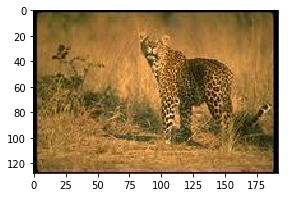

In [15]:
x.show(figsize=(6,3), hide_axis=False)
print(x.shape)

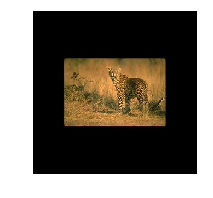

In [11]:
crop_pad(xi(), 300, row_pct=0.,col_pct=0., padding_mode='constant').show()

In [16]:
crop_pad(xi(), 300, row_pct=0.,col_pct=0., padding_mode='constant').shape

torch.Size([3, 300, 300])

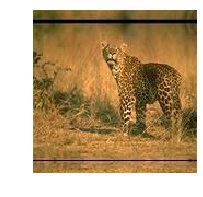

In [12]:
crop_pad(xi(), 150).show()

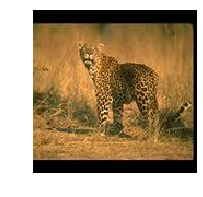

In [13]:
crop_pad(xi(), 150, row_pct=0.,col_pct=0.98, padding_mode='constant').show()

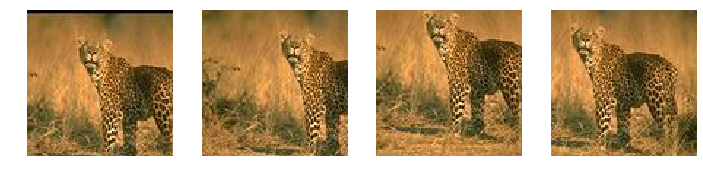

In [14]:
tfm = crop_pad(size=100, row_pct=(0,1.), col_pct=(0,1.))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes.flat:
    tfm.resolve()
    tfm(xi()).show(ax)

## Combine crop/resize

Next, we are going to combine our cropping and padding with the resize operation. In other words, we will get a picture, and crop/pad it in such a way that we get our desired size. It is similar to our previous transform only this time the final dimensions don't have to be square. This gives us more flexibility since our network architecture might take rectangular pictures as input.

First, we will get the target dimensions. For this we have built *get_crop_target*. This function takes three arguments: a target_px, a target_aspect and a multiple. *target_px* is our base dimension, *target_aspect* is our relation between width and height and _mult_ is what do we need our dimensions to be a multiple of. 

To understand this better, let's take our example where our values are *target_px*=220, *target_aspect*=2., _mult_=32 (default). In plain text we are telling our function: return the dimensions that meet a ~220\*220 area image with a width twice as long as the height and where height and width are multiples of 32.

In [17]:
#export
def round_multiple(x:int, mult:int)->int: 
    "Calc `x` to nearest multiple of `mult`"
    return (int(x/mult+0.5)*mult)

def get_crop_target(target_px:Union[int,Tuple[int,int]], mult:int=32)->Tuple[int,int]:
    "Calc crop shape of `target_px` to nearest multiple of `mult`"
    target_r,target_c = listify(target_px, 2)
    return round_multiple(target_r,mult),round_multiple(target_c,mult)

In [18]:
crop_target = get_crop_target(220)
target_r,target_c = crop_target
crop_target

(224, 224)

In [19]:
_,r,c = x.shape; x.shape

torch.Size([3, 128, 192])

We are now going to transform our image to our desired dimensions by using crop or padding. Before we crop or pad we will make an intermediate transform that will allow us to later get our output image with the desired dimensions. Let's call our initial dimensions h_i, w_i, our intermediate dimensions h_m, w_m and our output dimensions h_o, w_o.

Our objective will be to get our output image by cropping or padding but not both. To achive this, we will first enlarge or reduce our original image. **get_resize_target will enlarge or reduce our input image (keeping the shape or h_i/w_i constant) until one of the dimensions is equal to the corresponding final output dimension (i.e. h_m=h_o or w_m=w_o)**. But how does it know which dimension to equate? We can figure this out intuitively. If we intend to crop, our intermediate image's area has to be larger than our output image (since we are going to crop out some pixels) and if we intend to pad, our intermediate image's area has to be smaller than our output image (since we will add some pixels). This means that the dimension we will chose to equate will depend on the relationship between the ratios h_i/h_0 and w_i/w_o. If we want to **crop** we will want to equate the dimension with **the smallest ratio** since that would mean that (h_m, w_m) >= (h_o, w_o) which is exactly what we want (a larger area). Conversely if we want to **pad**, we will equate the dimension with **the largest ratio** since that will guarantee that (h_m, w_m) <= (h_o, w_o) (a smaller area).

As an example say we have our image with dimensions h_i = 192 and w_i = 128 and our target dimensions are h_o=160 w_o=320. That is, we have to turn a vertical rectangle into a horizontal rectangle. We can do this in to ways:

1. Padding the borders so we make our image wider
2. Cropping the top and bottom so we squash our image and make it wider

If we intend to crop, our intermediate dimensions will be (h_m, w_m) = (480, 320). If we intend to pad (h_m, w_m) = (160, 107). Note that 480/320 ≈ 160/107 ≈ 192/128.

In [20]:
r_ratio = r/target_r
c_ratio = c/target_c
# min -> crop; max -> pad
ratio = max(r_ratio,c_ratio)
r_ratio,c_ratio,ratio

(0.5714285714285714, 0.8571428571428571, 0.8571428571428571)

In [21]:
r2,c2 = round(r/ratio),round(c/ratio); r2,c2

(149, 224)

In [22]:
#export
def get_resize_target(img, crop_target, do_crop=False)->TensorImageSize:
    "Calc size of `img` to fit in `crop_target` - adjust based on `do_crop`"
    if crop_target is None: return None
    ch,r,c = img.shape
    target_r,target_c = crop_target
    ratio = (min if do_crop else max)(r/target_r, c/target_c)
    return ch,round(r/ratio),round(c/ratio)

In [23]:
get_resize_target(x, crop_target, False)

(3, 149, 224)

In [24]:
get_resize_target(x, crop_target, True)

(3, 224, 336)

In [25]:
#export
def is_listy(x:Any)->bool: return isinstance(x, (tuple,list))

def apply_tfms(tfms:TfmList, x:TensorImage, do_resolve:bool=True, 
               xtra:Optional[Dict[Transform,dict]]=None, size:Optional[Union[int,TensorImageSize]]=None,
               mult:int=32, do_crop:bool=True, padding_mode:str='reflect', **kwargs:Any)->TensorImage:
    "Apply all `tfms` to `x` - `do_resolve`: bind random args - size,mult used to crop/pad"
    if tfms or xtra or size:
        if not xtra: xtra={}
        tfms = sorted(listify(tfms), key=lambda o: o.tfm.order)
        if do_resolve: resolve_tfms(tfms)
        x = x.clone()
        x.set_sample(padding_mode=padding_mode, **kwargs)
        if size:
            crop_target = get_crop_target(size, mult=mult)
            target = get_resize_target(x, crop_target, do_crop=do_crop)
            x.resize(target)

        size_tfms = [o for o in tfms if isinstance(o.tfm,TfmCrop)]
        for tfm in tfms:
            if tfm.tfm in xtra: x = tfm(x, **xtra[tfm.tfm])
            elif tfm in size_tfms: x = tfm(x, size=size, padding_mode=padding_mode)
            else: x = tfm(x)
    return x

import nb_002
nb_002.apply_tfms = apply_tfms

torch.Size([3, 210, 210])

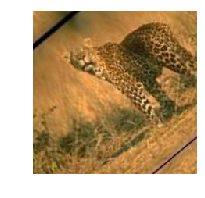

In [26]:
tfms = [rotate(degrees=(40.,40.)),
        crop_pad()]

img = apply_tfms(tfms, x, size=210)
img.show(figsize=(6,3))
img.shape

((224, 224), torch.Size([3, 210, 210]))

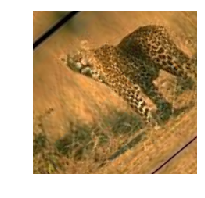

In [27]:
tfms = [rotate(degrees=(40.,40.)),
       crop_pad(row_pct=(0,1.), col_pct=(0,1.))]

img = apply_tfms(tfms, x, size=210)
img.show(figsize=(6,3))
get_crop_target(210), img.shape

# Fit

Let's see how our transforms look for different values of zoom, rotate and crop_pad.

## Transform

In [28]:
#export
def rand_zoom(*args, **kwargs):
    "Random zoom tfm"
    return zoom(*args, row_pct=(0,1), col_pct=(0,1), **kwargs)
def rand_crop(*args, **kwargs): 
    "Random crop and pad"
    return crop_pad(*args, row_pct=(0,1), col_pct=(0,1), **kwargs)
def zoom_crop(scale, do_rand=False, p=1.0):
    "Randomly zoom and/or crop"
    zoom_fn = rand_zoom if do_rand else zoom
    crop_fn = rand_crop if do_rand else crop_pad
    return [zoom_fn(scale=scale, p=p), crop_fn()]

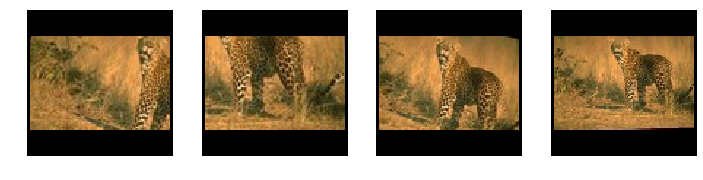

In [29]:
tfms = [
    rotate(degrees=(-20,20.)),
    *zoom_crop(scale=(1.,1.95), do_rand=True)
]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes.flat:
    apply_tfms(tfms, x, padding_mode='zeros', do_crop=False, size=100).show(ax)

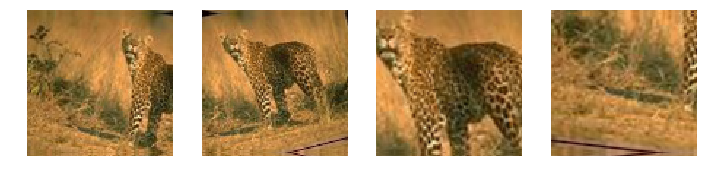

In [30]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes.flat: apply_tfms(tfms, x, size=100).show(ax)

## Fit

Finally, with our choice of transforms and parameters we are going to fit our Darknet model and check our results. To fit our model we will need to resize our images to have the same size so we can feed them in batches to our model. We face the same decisions as before. 

In this case we chose to pad our images (since in \_apply_affine do_crop default is False). If we wanted to crop instead, we can easily add do_crop=True to train_tds. 

We also decided to make our images square, with dimension size x size. If we wanted a rectangle with width to height ratio *a* we could have added aspect=*a* to train_ds.

In [31]:
size = 150

In [32]:
train_tfms = [
    rotate(degrees=(-20,20.)),
    *zoom_crop(scale=(1.,2.))
]
valid_tfms = [crop_pad()]

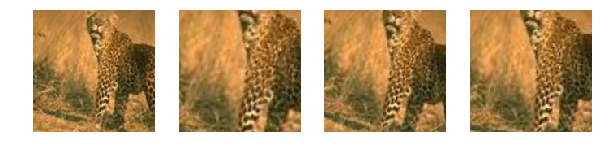

In [33]:
_,axes = plt.subplots(1,4, figsize=(10,5))
for ax in axes.flat: apply_tfms(train_tfms, x, size=size).show(ax)

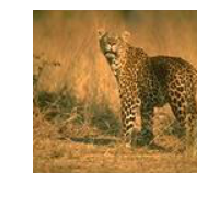

In [34]:
apply_tfms(valid_tfms, x, size=size).show()

In [35]:
bs = 128

In [36]:
valid_tds = DatasetTfm(valid_ds, valid_tfms, size=size)
train_tds = DatasetTfm(train_ds, train_tfms, size=size)
data = DataBunch.create(train_tds, valid_tds, bs=bs, num_workers=0)
xb,yb = next(iter(data.train_dl))
b = xb.transpose(1,0).reshape(3,-1)
data_mean=b.mean(1).cpu()
data_std=b.std(1).cpu()
data_mean,data_std

(tensor([0.5362, 0.4942, 0.4637]), tensor([0.2803, 0.2687, 0.2869]))

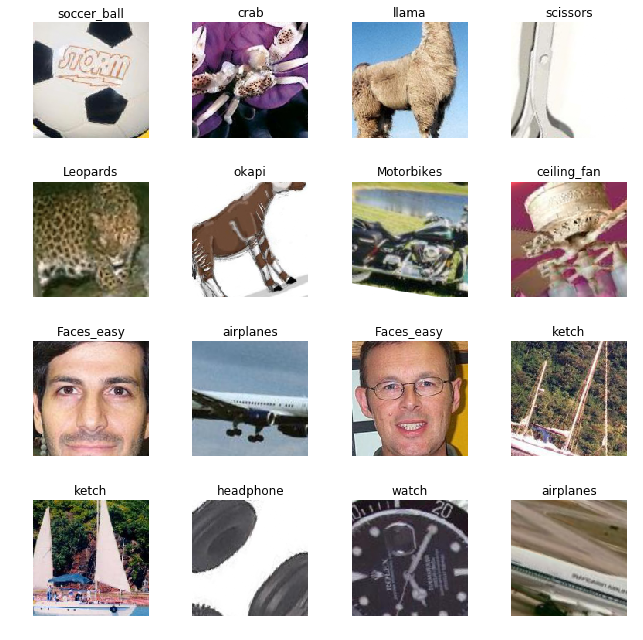

In [37]:
show_image_batch(data.train_dl, train_ds.classes, 4)

In [38]:
norm,denorm = normalize_funcs(data_mean,data_std)

In [39]:
data = DataBunch.create(train_tds, valid_tds, bs=bs, num_workers=12, tfms=norm)
len(data.train_dl),len(data.valid_dl)

(57, 8)

In [40]:
model = Darknet([1, 2, 4, 4, 2], num_classes=c, nf=16)
learn = Learner(data, model)
opt_fn = partial(optim.SGD, momentum=0.9)

In [41]:
learn.fit(1, 0.1, opt_fn=opt_fn)

0 4.832626014947891


In [42]:
learn.fit(1, 0.2, opt_fn=opt_fn)

0 7.115853935480118


In [43]:
learn.fit(5, 0.4, opt_fn=opt_fn)

0 3.9634300768375397
1 3.670086294412613
2 3.389945238828659
3 3.4216895401477814
4 3.261305257678032


In [44]:
learn.fit(5, 0.1, opt_fn=opt_fn)

0 2.736758418381214
1 2.755340874195099
2 2.6217730417847633
3 2.473929211497307
4 2.5602813437581062


In [45]:
learn.fit(5, 0.01, opt_fn=opt_fn)

0 2.276378870010376
1 2.2715221494436264
2 2.236018620431423
3 2.2417881041765213
4 2.211468055844307


# Fin